<a href="https://colab.research.google.com/github/Freedisch/Anime-Girls-Holding-Programming-Books/blob/master/covidchat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Epoch 1/50
12/12 [==============================] - 1s 5ms/step - loss: 3.6352 - accuracy: 0.0556 
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 3.5835 - accuracy: 0.0556
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 3.4990 - accuracy: 0.0972
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 3.4640 - accuracy: 0.0903
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 3.3841 - accuracy: 0.1181
Epoch 6/50
12/12 [==============================] - 0s 7ms/step - loss: 3.2752 - accuracy: 0.1667
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 3.1679 - accuracy: 0.1736
Epoch 8/50
12/12 [==============================] - 0s 8ms/step - loss: 3.1740 - accuracy: 0.1528
Epoch 9/50
12/12 [==============================] - 0s 7ms/step - loss: 3.0644 - accuracy: 0.1667
Epoch 10/50
12/12 [==============================] - 0s 9ms/step - loss: 2.9228 - accuracy: 0.2083
Epoch 11/50
12/12 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Done


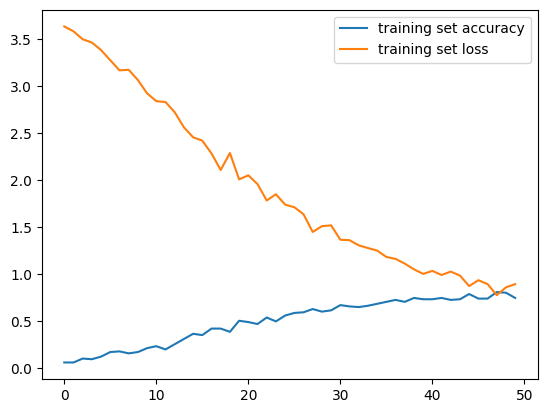

GO! BOT IS RUNNING
what is coronavirus
1/1 [==============================] - 0s 65ms/step
Bot: 
The clinical spectrum of COVID-19 ranges from mild disease with non-specific signs and symptoms of acute respiratory illness, to severe pneumonia with respiratory failure and septic shock. There have also been reports of asymptomatic infection with COVID-19. See also Interim Clinical Guidance for Management of Patients with Confirmed Coronavirus Disease 2019 (COVID-19). For more information Center for Disease Control and Prevention (CDC)
how to prevent from coronavirus
1/1 [==============================] - 0s 32ms/step
Bot: Waste generated in the care of PUIs or patients with confirmed COVID-19 does not present additional considerations for wastewater disinfection in the United States. Coronaviruses are susceptible to the same disinfection conditions in community and healthcare settings as other viruses, so current disinfection conditions in wastewater treatment facilities are expected to 

In [ ]:
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

df = pd.read_csv("Covidvert.csv")
df.dropna(inplace=True)

dict_ = {"intents":[]}
for ind in df.index:
    ques = df['Questions'][ind].lower()
    ques = ques.replace('?', '.')
    ques += df['Tags'][ind].lower()
    ques = ques.split('.')
    for i, q in enumerate(ques):
        ques[i] = q.strip()
    ans = df['Answers'][ind] + " Check the " + df['Source'][ind]
    dict1 = {'tags': df['Tags'][ind]}
    dict1['patterns'] = ques[:-1]
    dict1['responses'] = ans
    dict_['intents'].append(dict1)

with open("covid.json", "w") as f:
    f.write(json.dumps(dict_))

with open('covid.json') as json_file:
    intents = json.load(json_file)

words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']

for intent in intents['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            pattern = pattern.strip()
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags']))
            if intent['tags'] not in classes:
                classes.append(intent['tags'])

lemmatizer = WordNetLemmatizer()

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

train_x = []
train_y = []
output_empty = [0] * len(classes)

for doc in documents:
    bag = []
    pattern_words = doc[0].split()
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    for word in words:
        bag.append(1) if word in pattern_words else bag.append(0)
    train_x.append(bag)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    train_y.append(output_row)

train_x = np.array(train_x)
train_y = np.array(train_y)

model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(np.array(train_x), np.array(train_y), epochs=50, batch_size=12, verbose=1)
model.save('chatbotmodel.h5', hist)
print('Training Done')

plt.plot(hist.history['accuracy'], label='training set accuracy')
plt.plot(hist.history['loss'], label='training set loss')
plt.legend()
plt.show()

from tensorflow.keras.models import load_model

with open('covid.json') as json_file:
    intents = json.load(json_file)

words = pickle.load(open('words.pkl', 'rb'))
classes = pickle.load(open('classes.pkl', 'rb'))
model = load_model('chatbotmodel.h5')

embedding_adjuster = Sequential()
embedding_adjuster.add(Dense(len(train_x[0]), input_shape=(768,), activation='relu'))

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    adjusted_embedding = embedding_adjuster.predict(embedding)
    res = model.predict(adjusted_embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({'intent': classes[r[0]], 'probability': str(r[1])})
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if tag in i['tags']:
            return i['responses']
    return None

print("GO! BOT IS RUNNING")

while True:
    message = input("")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye")
        break
    ints = predict_class(message)
    if len(ints) > 0:
        res = get_response(ints, intents)
        print(f"Bot: {res}")
